In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")

try:
    from ultralytics import YOLO
    print("Ultralytics import successful")
except Exception as e:
    print(f"Lỗi khi import ultralytics: {e}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm-

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import shutil
from tqdm.auto import tqdm
from pathlib import Path
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon

from ultralytics import YOLO

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
class Config:
    data_dir = '/kaggle/input/vietnamese-receipts-mc-ocr-2021'
    image_dir = '/kaggle/input/vietnamese-receipts-mc-ocr-2021/preprocessor/preprocessor/imgs'
    label_dir = '/kaggle/input/vietnamese-receipts-mc-ocr-2021/dataset/text_detector/txt'
    
    output_dir = '/kaggle/working/output'
    yolo_dataset_dir = '/kaggle/working/dataset_yolo'
    
    batch_size = 16
    img_size = 640
    epochs = 50
    
    train_ratio = 0.8
    val_ratio = 0.1
    test_ratio = 0.1

os.makedirs(Config.output_dir, exist_ok=True)
os.makedirs(Config.yolo_dataset_dir, exist_ok=True)

In [ ]:
def convert_to_yolo_format(image_path, label_path, output_dir, class_id=0):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Không thể đọc ảnh {image_path}")
        return False
    
    img_height, img_width = img.shape[:2]
    
    try:
        with open(label_path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
    except Exception as e:
        print(f"Lỗi khi đọc file {label_path}: {str(e)}")
        return False
    
    image_name = os.path.basename(image_path)
    output_label_path = os.path.join(output_dir, os.path.splitext(image_name)[0] + '.txt')
    
    with open(output_label_path, 'w', encoding='utf-8') as out_file:
        for line in lines:
            line = line.strip()
            if not line:
                continue
            
            try:
                coords = [float(coord) for coord in line.split(',') if coord]
                
                if len(coords) != 8:
                    print(f"Sai định dạng bounding box trong {label_path}: {line}")
                    continue
                
                x_coords = [coords[i] for i in range(0, len(coords), 2)]
                y_coords = [coords[i] for i in range(1, len(coords), 2)]
                
                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)
                
                x_center = (x_min + x_max) / (2 * img_width)
                y_center = (y_min + y_max) / (2 * img_height)
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height
                
                if width <= 0 or height <= 0:
                    continue
                
                x_center = max(0, min(1, x_center))
                y_center = max(0, min(1, y_center))
                width = max(0, min(1, width))
                height = max(0, min(1, height))
                
                yolo_line = f"{class_id} {x_center} {y_center} {width} {height}\n"
                out_file.write(yolo_line)
                
            except Exception as e:
                print(f"Lỗi khi xử lý line trong {label_path}: {line} - {str(e)}")
                continue
    
    return True

In [ ]:
def prepare_yolo_dataset():
   
    
    for split in ['train', 'val', 'test']:
        for subdir in ['images', 'labels']:
            os.makedirs(os.path.join(Config.yolo_dataset_dir, split, subdir), exist_ok=True)
    
    all_images = glob.glob(os.path.join(Config.image_dir, '*.jpg'))
    print(f"Tìm thấy {len(all_images)} ảnh.")
    
    random.shuffle(all_images)
    
    total_images = len(all_images)
    train_count = int(total_images * Config.train_ratio)
    val_count = int(total_images * Config.val_ratio)
    
    train_images = all_images[:train_count]
    val_images = all_images[train_count:train_count + val_count]
    test_images = all_images[train_count + val_count:]
    
    print(f"Chia thành: {len(train_images)} ảnh train, {len(val_images)} ảnh val, {len(test_images)} ảnh test")
    
    datasets = {
        'train': train_images,
        'val': val_images,
        'test': test_images
    }
    
    for split, images in datasets.items():
        print(f"Đang xử lý tập {split}...")
        success_count = 0
        
        for img_path in tqdm(images):
            img_filename = os.path.basename(img_path)
            img_name_no_ext = os.path.splitext(img_filename)[0]
            
            label_path = os.path.join(Config.label_dir, img_name_no_ext + '.txt')
            
            if not os.path.exists(label_path):
                continue
            
            dst_img_path = os.path.join(Config.yolo_dataset_dir, split, 'images', img_filename)
            
            try:
                shutil.copy(img_path, dst_img_path)
            except Exception as e:
                print(f"Lỗi khi copy ảnh {img_path}: {str(e)}")
                continue
            
            success = convert_to_yolo_format(
                img_path, 
                label_path, 
                os.path.join(Config.yolo_dataset_dir, split, 'labels')
            )
            
            if success:
                success_count += 1
        
        print(f"Đã xử lý thành công {success_count}/{len(images)} ảnh trong tập {split}")
    
    yaml_content = f"""
path: {Config.yolo_dataset_dir}  # dataset root dir
train: train/images  # train images
val: val/images  # val images
test: test/images  # test images (optional)

# Classes
nc: 1  # number of classes
names: ['text']  # class names
"""
    
    with open(os.path.join(Config.yolo_dataset_dir, 'dataset.yaml'), 'w') as f:
        f.write(yaml_content)
    
    print(f"Đã tạo xong dataset theo định dạng YOLOv8 tại {Config.yolo_dataset_dir}")
    return os.path.join(Config.yolo_dataset_dir, 'dataset.yaml')

In [ ]:
dataset_yaml_path = prepare_yolo_dataset()

Đang chuẩn bị dữ liệu cho YOLOv5...
Tìm thấy 1155 ảnh.
Chia thành: 924 ảnh train, 115 ảnh val, 116 ảnh test
Đang xử lý tập train...


  0%|          | 0/924 [00:00<?, ?it/s]

Đã xử lý thành công 924/924 ảnh trong tập train
Đang xử lý tập val...


  0%|          | 0/115 [00:00<?, ?it/s]

Đã xử lý thành công 115/115 ảnh trong tập val
Đang xử lý tập test...


  0%|          | 0/116 [00:00<?, ?it/s]

Đã xử lý thành công 116/116 ảnh trong tập test
Đã tạo xong dataset theo định dạng YOLOv5 tại /kaggle/working/dataset_yolo


In [ ]:
def train_yolov8():
    """
    Huấn luyện YOLOv8 trên dataset đã chuẩn bị.
    """
    print("Bắt đầu huấn luyện YOLOv8...")
    
    model = YOLO('yolov8n.pt')  
    print("Khởi tạo model YOLOv8 thành công")
    
    results = model.train(
        data=dataset_yaml_path,
        epochs=Config.epochs,
        imgsz=Config.img_size,
        batch=Config.batch_size,
        name='yolov8_receipts_text_detection',
        device='0' if torch.cuda.is_available() else 'cpu',
        patience=10  
    )
    
    print("Đã hoàn thành huấn luyện YOLOv8!")
    
    model_path = Path('runs/detect/yolov8_receipts_text_detection/weights/best.pt')
    if model_path.exists():
        shutil.copy(str(model_path), os.path.join(Config.output_dir, 'yolov8_best.pt'))
        print(f"Đã lưu model tốt nhất tại {os.path.join(Config.output_dir, 'yolov8_best.pt')}")
    else:
        print("Không tìm thấy file model best.pt!")
    
    return model



In [ ]:
print("Thử huấn luyện với YOLOv8...")
model = train_yolov8()


Thử huấn luyện với YOLOv8...
Bắt đầu huấn luyện YOLOv8...


100%|██████████| 6.25M/6.25M [00:00<00:00, 85.4MB/s]


Khởi tạo model YOLOv8 thành công
Ultralytics 8.3.125 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/dataset_yolo/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8_receipts_text_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

100%|██████████| 755k/755k [00:00<00:00, 16.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 73.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1795.3±439.5 MB/s, size: 121.1 KB)


train: Scanning /kaggle/working/dataset_yolo/train/labels... 924 images, 0 backgrounds, 0 corrupt: 100%|██████████| 924/924 [00:00<00:00, 1171.36it/s]

train: New cache created: /kaggle/working/dataset_yolo/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 399.7±127.3 MB/s, size: 77.9 KB)


val: Scanning /kaggle/working/dataset_yolo/val/labels... 115 images, 0 backgrounds, 0 corrupt: 100%|██████████| 115/115 [00:00<00:00, 1003.89it/s]

val: New cache created: /kaggle/working/dataset_yolo/val/labels.cache


Plotting labels to runs/detect/yolov8_receipts_text_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8_receipts_text_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.61G      1.717       1.81      1.212        873        640: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


                   all        115       4546      0.849      0.755      0.841      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.62G       1.29     0.8986      1.033        822        640: 100%|██████████| 58/58 [00:10<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

                   all        115       4546      0.828      0.791      0.848      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.42G      1.248     0.8456      1.005        796        640: 100%|██████████| 58/58 [00:10<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

                   all        115       4546      0.885      0.831      0.893      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.42G      1.267     0.8325      1.005       1175        640: 100%|██████████| 58/58 [00:10<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

                   all        115       4546       0.88      0.832      0.899      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.42G      1.192     0.7887     0.9876       1078        640: 100%|██████████| 58/58 [00:10<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

                   all        115       4546      0.893      0.839      0.913      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.42G      1.205     0.7737     0.9835        909        640: 100%|██████████| 58/58 [00:10<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

                   all        115       4546      0.909       0.86      0.922      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.42G      1.144     0.7355     0.9733       1252        640: 100%|██████████| 58/58 [00:10<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

                   all        115       4546      0.897      0.857      0.919      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.42G      1.117     0.7217     0.9588       1132        640: 100%|██████████| 58/58 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all        115       4546      0.909      0.866       0.93      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.42G      1.086     0.6916     0.9534       1021        640: 100%|██████████| 58/58 [00:10<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all        115       4546      0.917      0.866       0.93      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.42G      1.086     0.6877     0.9474        935        640: 100%|██████████| 58/58 [00:10<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]

                   all        115       4546      0.912      0.871       0.93      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.42G      1.088     0.6859     0.9461        833        640: 100%|██████████| 58/58 [00:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]

                   all        115       4546        0.9      0.857      0.924       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.42G      1.064     0.6665     0.9431        800        640: 100%|██████████| 58/58 [00:11<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

                   all        115       4546      0.922      0.879       0.94      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.42G       1.05      0.664     0.9413        723        640: 100%|██████████| 58/58 [00:11<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]

                   all        115       4546      0.929      0.877      0.939       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.42G      1.061      0.662     0.9436       1190        640: 100%|██████████| 58/58 [00:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all        115       4546      0.934      0.872      0.937      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.42G      1.032     0.6408     0.9357        780        640: 100%|██████████| 58/58 [00:11<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

                   all        115       4546      0.934       0.87      0.939      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.42G      1.041     0.6365     0.9328        952        640: 100%|██████████| 58/58 [00:10<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]

                   all        115       4546      0.923      0.883      0.941      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.42G       1.01     0.6207     0.9296        859        640: 100%|██████████| 58/58 [00:11<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.48it/s]

                   all        115       4546      0.932      0.885      0.947      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.42G      1.024     0.6144     0.9314        898        640: 100%|██████████| 58/58 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

                   all        115       4546      0.933      0.874      0.942       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.42G      1.002     0.6127     0.9285       1102        640: 100%|██████████| 58/58 [00:10<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

                   all        115       4546      0.939      0.884      0.944      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.42G      1.002     0.6046     0.9255        937        640: 100%|██████████| 58/58 [00:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

                   all        115       4546      0.926      0.886      0.949      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.42G     0.9965     0.6015     0.9246       1066        640: 100%|██████████| 58/58 [00:11<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

                   all        115       4546      0.932      0.883      0.949      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.42G     0.9919     0.5993     0.9215       1055        640: 100%|██████████| 58/58 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]

                   all        115       4546       0.91      0.898      0.944      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.42G     0.9962     0.5938     0.9199        676        640: 100%|██████████| 58/58 [00:11<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

                   all        115       4546      0.921      0.896      0.946       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.42G       1.01     0.6007     0.9237       1298        640: 100%|██████████| 58/58 [00:11<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

                   all        115       4546      0.922      0.893      0.951      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.42G     0.9651     0.5742      0.913        725        640: 100%|██████████| 58/58 [00:10<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

                   all        115       4546      0.929       0.89      0.947      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.42G     0.9823     0.5806     0.9175        877        640: 100%|██████████| 58/58 [00:11<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]

                   all        115       4546      0.926      0.881      0.948      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.42G     0.9892     0.5886     0.9159        968        640: 100%|██████████| 58/58 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

                   all        115       4546      0.927      0.897       0.95      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.42G     0.9687     0.5764     0.9153       1068        640: 100%|██████████| 58/58 [00:11<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]

                   all        115       4546      0.941      0.884      0.951       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.42G     0.9816     0.5807     0.9151        808        640: 100%|██████████| 58/58 [00:10<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

                   all        115       4546       0.93      0.889      0.951      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.42G     0.9497     0.5644     0.9124        935        640: 100%|██████████| 58/58 [00:11<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

                   all        115       4546      0.932      0.885      0.951       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.42G     0.9456      0.556     0.9083        612        640: 100%|██████████| 58/58 [00:10<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

                   all        115       4546      0.931      0.889      0.948      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.42G     0.9397     0.5562     0.9075       1192        640: 100%|██████████| 58/58 [00:11<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        115       4546      0.938       0.89      0.953       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.42G     0.9381     0.5515     0.9077        856        640: 100%|██████████| 58/58 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

                   all        115       4546      0.939      0.889      0.954       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.42G     0.9425     0.5549       0.91        935        640: 100%|██████████| 58/58 [00:10<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all        115       4546      0.937      0.888       0.95      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.42G     0.9268     0.5442     0.9054        904        640: 100%|██████████| 58/58 [00:11<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

                   all        115       4546      0.937      0.892      0.953      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.42G     0.9284     0.5415     0.9047        976        640: 100%|██████████| 58/58 [00:11<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

                   all        115       4546      0.936      0.893      0.951        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.42G      0.931     0.5413     0.9052        966        640: 100%|██████████| 58/58 [00:11<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

                   all        115       4546      0.944      0.889      0.951      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.42G     0.9065     0.5329     0.8997        743        640: 100%|██████████| 58/58 [00:11<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

                   all        115       4546      0.936      0.894      0.955      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.42G     0.9136     0.5401     0.9028       1016        640: 100%|██████████| 58/58 [00:11<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]

                   all        115       4546      0.945      0.883      0.954      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.42G     0.9204     0.5325     0.8994        913        640: 100%|██████████| 58/58 [00:11<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

                   all        115       4546      0.933      0.897      0.953      0.722


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.42G     0.8848     0.5321     0.8944        586        640: 100%|██████████| 58/58 [00:11<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


                   all        115       4546      0.939      0.886      0.948        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.42G     0.8797     0.5238     0.8925        383        640: 100%|██████████| 58/58 [00:10<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

                   all        115       4546      0.944      0.889      0.955      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.42G     0.8737     0.5173     0.8923        367        640: 100%|██████████| 58/58 [00:10<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]

                   all        115       4546      0.936      0.895      0.954      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.42G     0.8647     0.5123     0.8887        471        640: 100%|██████████| 58/58 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

                   all        115       4546      0.941      0.896      0.955      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.42G      0.854     0.5042     0.8855        400        640: 100%|██████████| 58/58 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

                   all        115       4546      0.942      0.901      0.956      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.42G     0.8517     0.5014     0.8807        561        640: 100%|██████████| 58/58 [00:10<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

                   all        115       4546      0.938      0.901      0.957       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.42G      0.833     0.4952      0.881        430        640: 100%|██████████| 58/58 [00:09<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]

                   all        115       4546      0.939      0.892      0.957      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.42G     0.8394     0.4927     0.8827        361        640: 100%|██████████| 58/58 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

                   all        115       4546      0.936        0.9      0.956      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.42G     0.8307     0.4885     0.8796        418        640: 100%|██████████| 58/58 [00:10<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

                   all        115       4546       0.95      0.885      0.958      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.42G     0.8295     0.4917     0.8815        539        640: 100%|██████████| 58/58 [00:09<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


                   all        115       4546      0.931      0.902      0.956      0.729

50 epochs completed in 0.168 hours.
Optimizer stripped from runs/detect/yolov8_receipts_text_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8_receipts_text_detection/weights/best.pt, 6.2MB

Validating runs/detect/yolov8_receipts_text_detection/weights/best.pt...
Ultralytics 8.3.125 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


                   all        115       4546      0.931      0.902      0.956      0.729


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/yolov8_receipts_text_detection
Đã hoàn thành huấn luyện YOLOv8!
Đã lưu model tốt nhất tại /kaggle/working/output/yolov8_best.pt


In [ ]:
def predict_on_image(model, image_path, conf_threshold=0.25):
    """
    Dự đoán text detection trên một ảnh sử dụng YOLO hoặc Faster R-CNN.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Không thể đọc ảnh {image_path}")
        return None, []
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    try:
        if 'YOLO' in str(type(model)):
            results = model.predict(image_path, conf=conf_threshold)
            
            boxes = []
            for result in results:
                for box in result.boxes:
                    
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = float(box.conf[0].cpu().numpy())
                    
                    box_points = np.array([
                        [x1, y1],
                        [x2, y1],
                        [x2, y2],
                        [x1, y2]
                    ], dtype=np.int32)
                    
                    boxes.append((box_points, conf))
        
        elif hasattr(model, 'predict'):
            results = model.predict(image_path, conf=conf_threshold)
            
            boxes = []
            for pred in results.pred:
                for *xyxy, conf, cls in pred:
                    x1, y1, x2, y2 = xyxy
                    
                    box_points = np.array([
                        [int(x1), int(y1)],
                        [int(x2), int(y1)],
                        [int(x2), int(y2)],
                        [int(x1), int(y2)]
                    ])
                    
                    boxes.append((box_points, float(conf)))
        
        elif 'torchvision' in str(type(model)):
            import torch
            from torchvision.transforms import functional as F
            
            img_tensor = F.to_tensor(image_rgb).unsqueeze(0)
            
            with torch.no_grad():
                predictions = model(img_tensor)
            
            boxes = []
            for i, box in enumerate(predictions[0]['boxes']):
                score = predictions[0]['scores'][i].item()
                
                if score >= conf_threshold:
                    x1, y1, x2, y2 = box.cpu().numpy()
                    
                    box_points = np.array([
                        [int(x1), int(y1)],
                        [int(x2), int(y1)],
                        [int(x2), int(y2)],
                        [int(x1), int(y2)]
                    ])
                    
                    boxes.append((box_points, score))
        
        else:
            print("Sử dụng OpenCV EAST Text Detector thay thế...")
            
            height, width = image.shape[:2]
            new_height = (height // 32) * 32
            new_width = (width // 32) * 32
            resized = cv2.resize(image, (new_width, new_height))
            
            blob = cv2.dnn.blobFromImage(resized, 1.0, (new_width, new_height), 
                                         (123.68, 116.78, 103.94), swapRB=True, crop=False)
            
            try:
                east_model_path = os.path.join(Config.output_dir, 'frozen_east_text_detection.pb')
                
                if not os.path.exists(east_model_path):
                    print("Downloading EAST text detector model...")
                    !wget -q -O {east_model_path} https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb
                
                if not os.path.exists(east_model_path):
                    print("Không tìm thấy model EAST, sử dụng phương pháp khác...")
                    return image_rgb, []
                
                net = cv2.dnn.readNet(east_model_path)
                
                output_layers = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
                
                net.setInput(blob)
                scores, geometry = net.forward(output_layers)
                
                boxes = []
                rects = []
                confidences = []
                
                height, width = scores.shape[2:4]
                for y in range(0, height):
                    scores_data = scores[0][0][y]
                    x_data0 = geometry[0][0][y]
                    x_data1 = geometry[0][1][y]
                    x_data2 = geometry[0][2][y]
                    x_data3 = geometry[0][3][y]
                    angles_data = geometry[0][4][y]
                    
                    for x in range(0, width):
                        score = float(scores_data[x])
                        
                        if score < conf_threshold:
                            continue
                        
                        offset_x = x * 4.0
                        offset_y = y * 4.0
                        
                        angle = angles_data[x]
                        cos = np.cos(angle)
                        sin = np.sin(angle)
                        
                        h = x_data0[x] + x_data2[x]
                        w = x_data1[x] + x_data3[x]
                        
                        endX = int(offset_x + (cos * x_data1[x]) + (sin * x_data2[x]))
                        endY = int(offset_y - (sin * x_data1[x]) + (cos * x_data2[x]))
                        startX = int(endX - w)
                        startY = int(endY - h)
                        
                        rects.append((startX, startY, endX, endY))
                        confidences.append(score)
                
                indices = cv2.dnn.NMSBoxes(rects, confidences, conf_threshold, 0.4)
                
                h_ratio = height / new_height
                w_ratio = width / new_width
                
                for i in indices:
                    if isinstance(i, list):
                        i = i[0]  
                        
                    (startX, startY, endX, endY) = rects[i]
                    
                    startX = int(startX * w_ratio)
                    startY = int(startY * h_ratio)
                    endX = int(endX * w_ratio)
                    endY = int(endY * h_ratio)
                    
                    box_points = np.array([
                        [startX, startY],
                        [endX, startY],
                        [endX, endY],
                        [startX, endY]
                    ])
                    
                    boxes.append((box_points, confidences[i]))
                
            except Exception as e:
                print(f"Lỗi khi sử dụng EAST text detector: {str(e)}")
                return image_rgb, []
    
    except Exception as e:
        print(f"Lỗi khi dự đoán: {str(e)}")
        return image_rgb, []
    
    return image_rgb, boxes

def visualize_detection_yolo(image, boxes, output_path=None):
    """
    Hiển thị kết quả text detection từ YOLOv8.
    """
    result_image = image.copy()
    
    for i, (box, conf) in enumerate(boxes):
        cv2.polylines(result_image, [box], True, (0, 255, 0), 2)
        
        x_center = np.mean(box[:, 0])
        y_center = np.mean(box[:, 1])
        
        cv2.putText(
            result_image, 
            f"{i+1} ({conf:.2f})", 
            (int(x_center), int(y_center)), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.5, 
            (0, 0, 255), 
            2
        )
    
    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
    
    plt.figure(figsize=(12, 12))
    plt.imshow(result_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return result_image

In [ ]:
def test_prediction():
    """
    Dự đoán trên một ảnh mẫu để kiểm tra kết quả.
    """
    test_images = sorted(glob.glob(os.path.join(Config.yolo_dataset_dir, 'test', 'images', '*.jpg')))
    
    if not test_images:
        test_images = sorted(glob.glob(os.path.join(Config.image_dir, '*.jpg')))
    
    if not test_images:
        print("Không tìm thấy ảnh nào để test!")
        return
    
    test_image_path = test_images[0]
    print(f"Dự đoán trên ảnh: {os.path.basename(test_image_path)}")
    
    image, boxes = predict_on_image(model, test_image_path)
    
    if image is not None:
        output_path = os.path.join(Config.output_dir, f'yolo_result_{os.path.basename(test_image_path)}')
        visualize_detection_yolo(image, boxes, output_path)
        
        print(f"Đã phát hiện {len(boxes)} vùng văn bản")
        print(f"Kết quả đã được lưu tại: {output_path}")

Dự đoán trên ảnh: mcocr_public_145013apigo.jpg

image 1/1 /kaggle/working/dataset_yolo/test/images/mcocr_public_145013apigo.jpg: 640x352 47 texts, 34.8ms
Speed: 2.4ms preprocess, 34.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


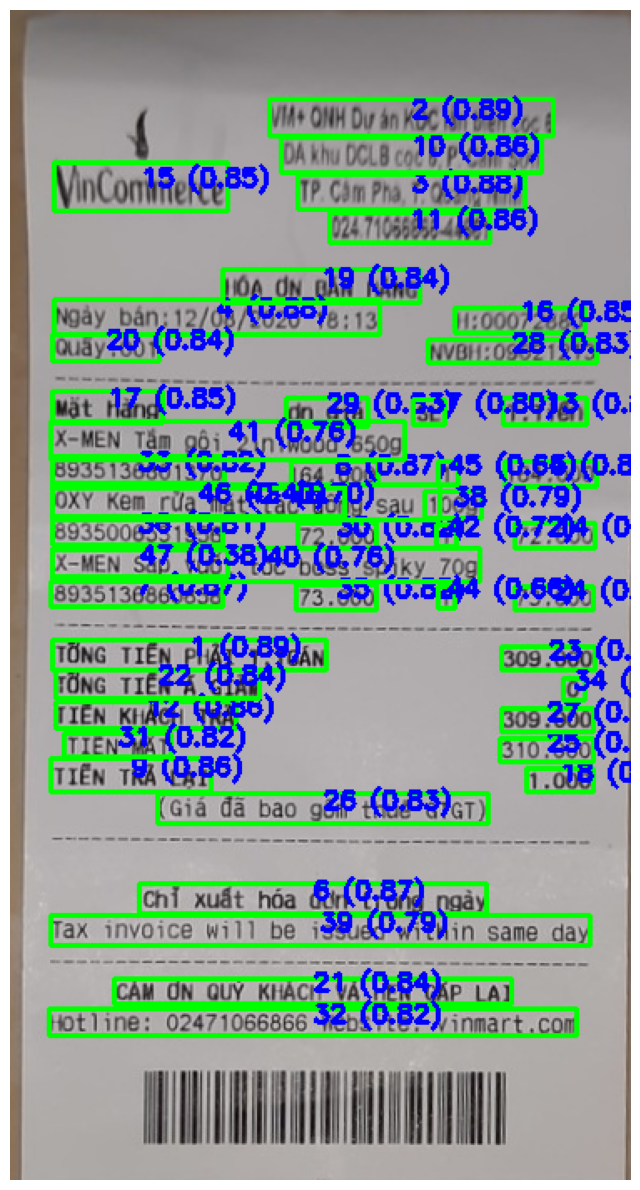

Đã phát hiện 47 vùng văn bản
Kết quả đã được lưu tại: /kaggle/working/output/yolo_result_mcocr_public_145013apigo.jpg


In [ ]:
test_prediction()

Dự đoán trên ảnh UNIQLO: mcocr_public_145013aagqw.jpg

image 1/1 /kaggle/input/vietnamese-receipts-mc-ocr-2021/preprocessor/preprocessor/imgs/mcocr_public_145013aagqw.jpg: 640x256 92 texts, 35.8ms
Speed: 2.2ms preprocess, 35.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


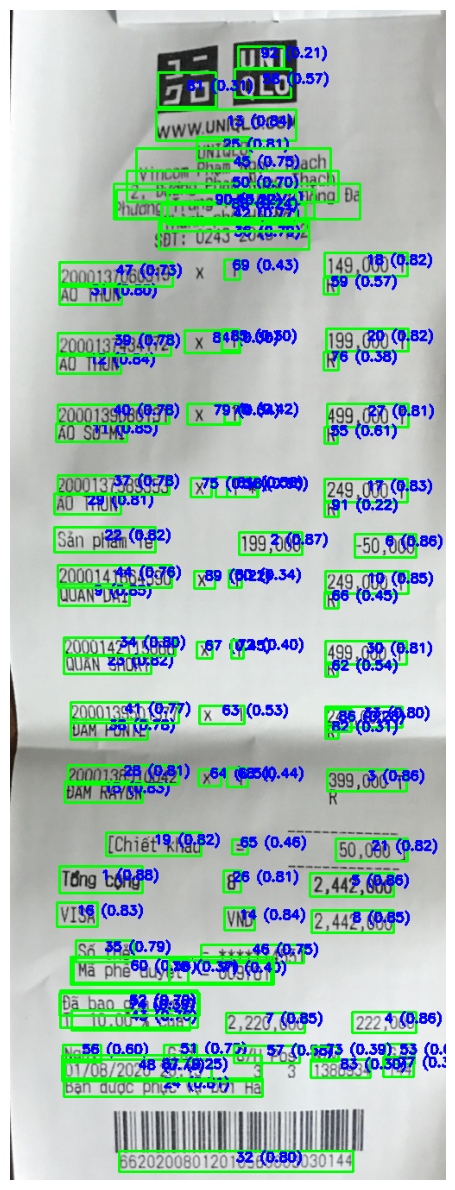

Đã phát hiện 92 vùng văn bản
Kết quả đã được lưu tại: /kaggle/working/output/yolo_result_uniqlo.jpg


In [ ]:
specific_image_path = "/kaggle/input/vietnamese-receipts-mc-ocr-2021/preprocessor/preprocessor/imgs/mcocr_public_145013aagqw.jpg"

if os.path.exists(specific_image_path):
    print(f"Dự đoán trên ảnh UNIQLO: {os.path.basename(specific_image_path)}")
    
    image, boxes = predict_on_image(model, specific_image_path, conf_threshold=0.2)
    
    if image is not None:
        output_path = os.path.join(Config.output_dir, f'yolo_result_uniqlo.jpg')
        visualize_detection_yolo(image, boxes, output_path)
        
        print(f"Đã phát hiện {len(boxes)} vùng văn bản")
        print(f"Kết quả đã được lưu tại: {output_path}")
else:
    print(f"Không tìm thấy ảnh tại đường dẫn: {specific_image_path}")

In [ ]:
def read_ground_truth_boxes(txt_path):
    """
    Đọc ground truth bounding boxes từ file txt.
    """
    boxes = []
    try:
        with open(txt_path, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                coords = [int(float(c)) for c in line.split(',') if c]
                if len(coords) != 8:
                    continue
                
                box = np.array(coords).reshape(4, 2)
                boxes.append(box)
    except Exception as e:
        print(f"Lỗi khi đọc file {txt_path}: {str(e)}")
    
    return boxes

def calculate_iou(box1, box2):
    """
    Tính IoU (Intersection over Union) giữa hai bounding box.
    """
    poly1 = Polygon(box1)
    poly2 = Polygon(box2)
    
    if not poly1.is_valid or not poly2.is_valid:
        return 0.0
    
    intersection_area = poly1.intersection(poly2).area
    union_area = poly1.area + poly2.area - intersection_area
    
    if union_area == 0:
        return 0.0
    
    return intersection_area / union_area

def evaluate_detection(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Đánh giá kết quả detection bằng các metrics: precision, recall, F1-score.
    """
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives
    
    # Danh sách các ground truth boxes đã được match
    matched_gt = set()
    
    for pred_box, _ in pred_boxes:
        # Tìm ground truth box có IoU cao nhất với predicted box
        best_iou = 0
        best_gt_idx = -1
        
        for idx, gt_box in enumerate(gt_boxes):
            if idx in matched_gt:
                continue  # Skip đã match
                
            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
        
        # Nếu IoU vượt ngưỡng, coi là true positive
        if best_iou >= iou_threshold and best_gt_idx not in matched_gt:
            tp += 1
            matched_gt.add(best_gt_idx)
        else:
            fp += 1  # False positive
    
    # Các ground truth boxes không được match là false negatives
    fn = len(gt_boxes) - len(matched_gt)
    
    # Tính precision, recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    }

In [14]:
def compare_with_ground_truth(image_path, model):
    """
    So sánh kết quả dự đoán với ground truth.
    """
    # Lấy đường dẫn đến file ground truth
    image_name = os.path.basename(image_path)
    image_name_no_ext = os.path.splitext(image_name)[0]
    gt_path = os.path.join(Config.label_dir, image_name_no_ext + '.txt')
    
    if not os.path.exists(gt_path):
        print(f"Không tìm thấy file ground truth: {gt_path}")
        return None
    
    # Đọc ground truth boxes
    gt_boxes = read_ground_truth_boxes(gt_path)
    
    # Dự đoán
    _, pred_boxes = predict_on_image(model, image_path, conf_threshold=0.2)
    
    # Đánh giá
    metrics = evaluate_detection(pred_boxes, gt_boxes)
    
    print(f"Kết quả đánh giá trên ảnh {image_name}:")
    print(f"  - Precision: {metrics['precision']:.4f}")
    print(f"  - Recall: {metrics['recall']:.4f}")
    print(f"  - F1-score: {metrics['f1_score']:.4f}")
    print(f"  - TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
    
    return metrics

In [15]:
# So sánh kết quả trên ảnh UNIQLO
if os.path.exists(specific_image_path):
    compare_with_ground_truth(specific_image_path, model)


image 1/1 /kaggle/input/vietnamese-receipts-mc-ocr-2021/preprocessor/preprocessor/imgs/mcocr_public_145013aagqw.jpg: 640x256 92 texts, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)
Kết quả đánh giá trên ảnh mcocr_public_145013aagqw.jpg:
  - Precision: 0.7717
  - Recall: 0.8452
  - F1-score: 0.8068
  - TP: 71, FP: 21, FN: 13


In [16]:
def evaluate_test_set():
    """
    Đánh giá kết quả trên toàn bộ tập test.
    """
    print("Đang đánh giá trên tập test...")
    
    test_images = sorted(glob.glob(os.path.join(Config.yolo_dataset_dir, 'test', 'images', '*.jpg')))
    
    if not test_images:
        print("Không tìm thấy ảnh nào trong tập test!")
        return
    
    # Giới hạn số lượng ảnh để đánh giá nhanh hơn (tùy chọn)
    test_images = test_images[:20]  # Chỉ đánh giá 20 ảnh đầu tiên
    
    total_metrics = {
        'precision': 0,
        'recall': 0,
        'f1_score': 0
    }
    
    valid_count = 0
    
    for img_path in tqdm(test_images):
        metrics = compare_with_ground_truth(img_path, model)
        
        if metrics:
            total_metrics['precision'] += metrics['precision']
            total_metrics['recall'] += metrics['recall']
            total_metrics['f1_score'] += metrics['f1_score']
            valid_count += 1
    
    if valid_count > 0:
        print("\nKết quả trung bình trên tập test:")
        print(f"  - Precision: {total_metrics['precision'] / valid_count:.4f}")
        print(f"  - Recall: {total_metrics['recall'] / valid_count:.4f}")
        print(f"  - F1-score: {total_metrics['f1_score'] / valid_count:.4f}")
    else:
        print("Không có ảnh nào được đánh giá thành công!")

In [17]:
# Đánh giá trên tập test
evaluate_test_set()

Đang đánh giá trên tập test...


  0%|          | 0/20 [00:00<?, ?it/s]


image 1/1 /kaggle/working/dataset_yolo/test/images/mcocr_public_145013apigo.jpg: 640x352 49 texts, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)
Kết quả đánh giá trên ảnh mcocr_public_145013apigo.jpg:
  - Precision: 0.9184
  - Recall: 1.0000
  - F1-score: 0.9574
  - TP: 45, FP: 4, FN: 0

image 1/1 /kaggle/working/dataset_yolo/test/images/mcocr_public_145013dcdmv.jpg: 640x384 35 texts, 35.9ms
Speed: 1.7ms preprocess, 35.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)
Kết quả đánh giá trên ảnh mcocr_public_145013dcdmv.jpg:
  - Precision: 0.9714
  - Recall: 1.0000
  - F1-score: 0.9855
  - TP: 34, FP: 1, FN: 0

image 1/1 /kaggle/working/dataset_yolo/test/images/mcocr_public_145013dkfnl.jpg: 640x352 49 texts, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)
Kết quả đánh giá trên ảnh mcocr_public_145013dkfnl.jpg:
  - Precision: 0.9184
  - Recall: 0.9000
  - F1-sc

In [18]:
def save_detection_results(image_path, output_dir):
    """
    Lưu kết quả phát hiện văn bản dưới dạng txt cho OCR.
    """
    # Tạo thư mục đầu ra nếu chưa tồn tại
    os.makedirs(output_dir, exist_ok=True)
    
    # Dự đoán
    _, boxes = predict_on_image(model, image_path, conf_threshold=0.2)
    
    # Lưu kết quả vào file txt
    image_name = os.path.basename(image_path)
    output_path = os.path.join(output_dir, os.path.splitext(image_name)[0] + '.txt')
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for box, _ in boxes:
            # Format: x1,y1,x2,y2,x3,y3,x4,y4
            box_str = ','.join([str(int(coord)) for coord in box.flatten()])
            f.write(box_str + '\n')
    
    print(f"Đã lưu kết quả detection tại: {output_path}")
    return output_path

In [19]:
# Lưu kết quả detection cho OCR
detection_output_dir = os.path.join(Config.output_dir, 'detection_results')

if os.path.exists(specific_image_path):
    output_path = save_detection_results(specific_image_path, detection_output_dir)
    
    print("Kết quả detection đã được lưu và sẵn sàng cho bước OCR tiếp theo.")
else:
    print(f"Không tìm thấy ảnh tại đường dẫn: {specific_image_path}")


image 1/1 /kaggle/input/vietnamese-receipts-mc-ocr-2021/preprocessor/preprocessor/imgs/mcocr_public_145013aagqw.jpg: 640x256 92 texts, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
Đã lưu kết quả detection tại: /kaggle/working/output/detection_results/mcocr_public_145013aagqw.txt
Kết quả detection đã được lưu và sẵn sàng cho bước OCR tiếp theo.
